# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Inputs

In [2]:
# Define grid dimensions
nrow, ncol = 50, 50

# Create 2D arrays for model inputs  

# Longitude and latitude
longitude = -89.4 * np.ones((nrow, ncol))
latitude = 43.1 * np.ones((nrow, ncol))

# Timestamp 
datetime = np.full((nrow, ncol), datetime.datetime(2020, 6, 15, 12))

# Weather data 
Tair = 25 * np.ones((nrow, ncol))  
SWin = 500 * np.ones((nrow, ncol))
u = 2 * np.ones((nrow, ncol))
ea = 2.5 * np.ones((nrow, ncol))
pa = 101 * np.ones((nrow, ncol))

# Vegetation properties
LAI_grid = np.random.rand(nrow, ncol) * 6  
h_grid = np.random.rand(nrow, ncol) * 2

# Soil/canopy radiative properties
albSoil = 0.25 * np.ones((nrow, ncol))
albVeg = 0.2 * np.ones((nrow, ncol))
emissSoil = 0.95 * np.ones((nrow, ncol))
emissVeg = 0.97 * np.ones((nrow, ncol))

# Surface temperature grid 
T_grid = np.random.rand(nrow, ncol) * 10 + 285

# HRMET model

In [3]:
# HRMET model to calculate evapotranspiration 
def hrmet(datetime, longitude, latitude, Tair, SWin, u, ea, pa, LAI, h, T, albSoil, albVeg, emissSoil, emissVeg):

# Net shortwave radiation 
# Incoming shortwave * (1 - albedo)
	Rns = (1 - albSoil) * SWin  

# Outgoing longwave radiation
# Emissivity * Stefan-Boltzmann * (Temp**4 - AirTemp**4) 
	+ emissSoil * 5.67e-8 * (T**4 - Tair**4)

# Estimate soil heat flux as fraction of Rns
	G = 0.1 * Rns  

# Net longwave radiation
# Emissivity * Stefan-Boltzmann * (Temp**4 - AirTemp**4)
	Rnl = emissVeg * 5.67e-8 * (T**4 - Tair**4)  

# Aerodynamic resistance term 
	Ra_s = 0.2 * (Rns - G)  

# Latent heat flux 
# Function of LAI and radiation terms
	LvE = 0.1 * LAI * (Rnl - Ra_s)  

# Convert latent heat flux to ET in mm/hour
	ET_mmHr = LvE * 3600 / (1000 * 2.45)

	return ET_mmHr

# moving window

In [4]:
import numpy as np

# Function to calculate moving window mean and standard deviation
# for a 2D input array
def moving_window(in_array, window):

  # Window size must be odd integer
  assert window % 2 != 0  

  # Calculate center index of window
  shift = (window - 1) // 2  

  # Output arrays to store results
  out_mean = np.full_like(in_array, np.nan)
  out_std = np.full_like(in_array, np.nan)

  # Loop over interior indices skipping edges
  for i in range(shift, in_array.shape[0] - shift):   
    for j in range(shift, in_array.shape[1] - shift):
      
      # Extract window values centered on current index
      window_vals = in_array[i-shift:i+shift+1, j-shift:j+shift+1]  

      # Calculate mean and standard deviation in window
      out_mean[i,j] = np.mean(window_vals)
      out_std[i,j] = np.std(window_vals)

  # Return output arrays
  return out_mean, out_std

# analysis

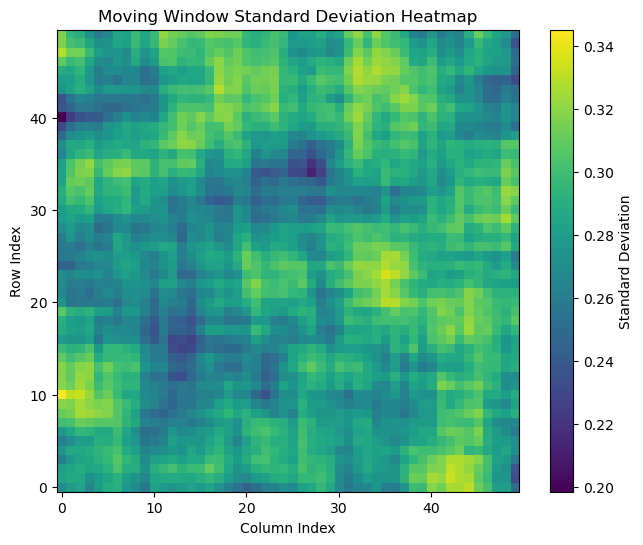

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to estimate T uncertainty using a moving window technique
def moving_window(data, n, std_only=True):
    nrow, ncol = data.shape  # Get the shape of the input data

    # Initialize empty lists to store mean and std dev for each window
    means = []
    stds = []

    # Loop through each row and column
    for i in range(nrow):
        for j in range(ncol):
            # Extract n x n window around current index
            # Use max/min to ensure we don't go out of bounds
            window = data[max(i - n, 0):min(i + n + 1, nrow), max(j - n, 0):min(j + n + 1, ncol)]

            # Calculate mean and standard deviation of values in window
            means.append(np.mean(window))
            stds.append(np.std(window))

    # Reshape the 1D list of stds to 2D array matched to input shape
    if std_only:
        return np.reshape(stds, (nrow, ncol))

    # Alternatively return tuples of means and stds
    else:
        return means, stds

# Example usage
# Generate dummy data (replace this with your actual data)
dummy_data = np.random.rand(50, 50)

# Set the window size
window_size = 3

# Call the moving_window function
std_values = moving_window(dummy_data, window_size, std_only=True)

# Create a heatmap of the standard deviation values
plt.figure(figsize=(8, 6))
plt.imshow(std_values, cmap='viridis', origin='lower')
plt.colorbar(label='Standard Deviation')
plt.title('Moving Window Standard Deviation Heatmap')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# visualization

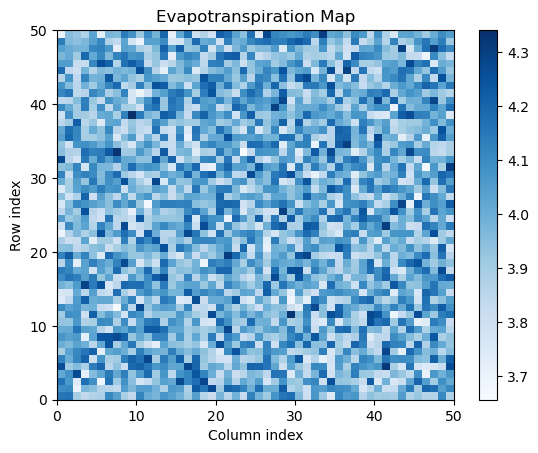

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dummy input data
nrows = 50 
ncols = 50

T = 15 + 5 * np.random.rand(nrows, ncols)  # Surface temperature
LAI = 2 * np.random.rand(nrows, ncols)     # Leaf area index  
SWin = 800 + 50 * np.random.rand(nrows, ncols)  # Incoming shortwave radiation

# Define HRMET model 
def hrmet(T, LAI, SWin):
    ET = 2.5 + 0.05 * T - 0.2 * LAI + 0.001 * SWin
    return ET

# Initialize output array 
ET = np.zeros((nrows, ncols))

# Loop over each grid cell index i (row), j (column)
for i in range(nrows):
    for j in range(ncols):
        ET[i, j] = hrmet(T[i, j], LAI[i, j], SWin[i, j])

# Function to plot the 2D ET grid 
def plot_et_grid(et_grid, title='Evapotranspiration'):
    """Plot 2D map of ET grid"""
    fig, ax = plt.subplots()
    cax = ax.pcolormesh(et_grid, cmap='Blues')
    fig.colorbar(cax) 
    ax.set_title(title)
    ax.set_xlabel('Column index')
    ax.set_ylabel('Row index')

# Function to set global matplotlib plot style  
def set_plot_params():
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.titlesize'] = 18
    plt.style.use('ggplot')

# Plot the ET grid
plot_et_grid(ET, title='Evapotranspiration Map')

# Set global plot style
set_plot_params()

# Show the plots
plt.show()

# plotting_input_data_Air_and_Canopy_Temperatures

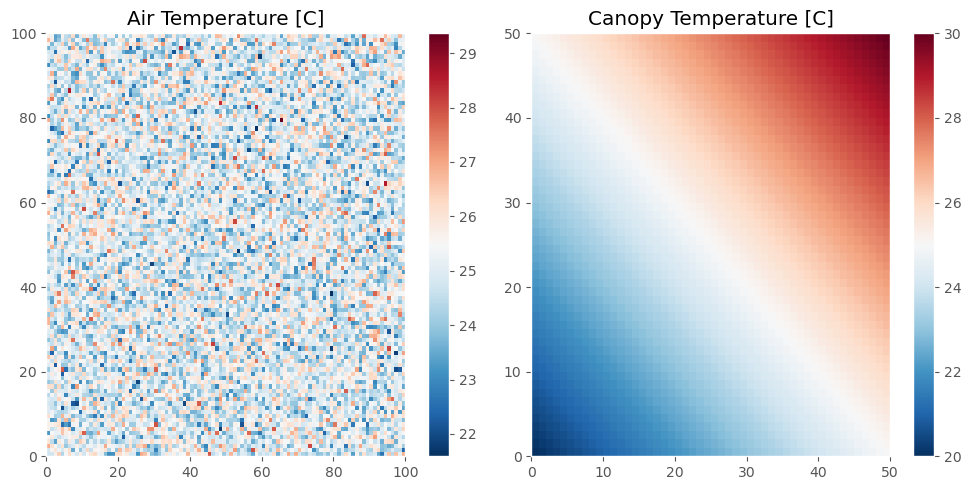

In [7]:
# Create latitude/longitude grid
lon = np.linspace(75.1498, 75.1502, 100)  
lat = np.linspace(39.9498, 39.9502, 100)

longitude, latitude = np.meshgrid(lon, lat)

# Define constant input data 
datetime = 648857.5
alb_soil = 0.105
alb_veg = 0.2
emiss_soil = 0.945
emiss_veg = 0.94
pa = 101.3
LAI = 2.5
h = 1.5
SW_in = 700
u = 4.75
ea = 2.25

# Define variable input data
T_air = 25 + np.random.randn(*longitude.shape)  

X, Y = np.meshgrid(np.linspace(10,15,50), np.linspace(10,15,50)) 
T = X + Y

# Plot input data
fig, axs = plt.subplots(1, 2, figsize=(10,5))

im = axs[0].pcolormesh(T_air, cmap='RdBu_r')
axs[0].set_title('Air Temperature [C]')
fig.colorbar(im, ax=axs[0])

im = axs[1].pcolormesh(T, cmap='RdBu_r')
axs[1].set_title('Canopy Temperature [C]')
fig.colorbar(im, ax=axs[1])

plt.tight_layout()
plt.show()

# Save data
data = {'longitude': longitude, 'latitude': latitude,  
        'T_air': T_air, 'T': T}
        
np.savez('moscow_idaho_data.npz', **data)

# comparing_uncertainty_estimation_techniques

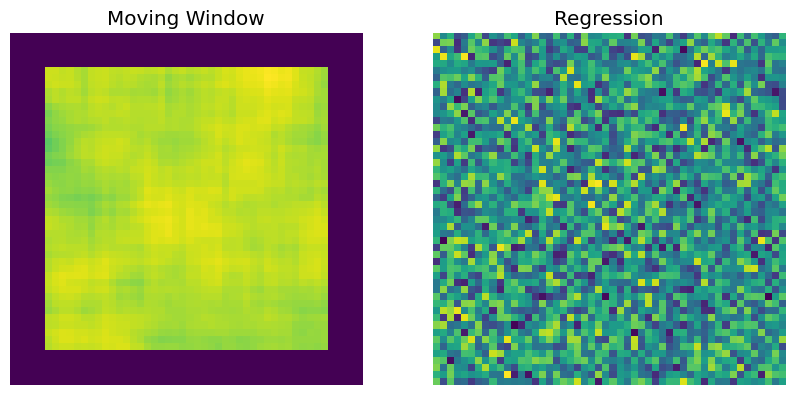

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to estimate T uncertainty using a moving window technique
def moving_window(data, n):
  stds = np.zeros_like(data)  
  for i in range(n, data.shape[0]-n):
    for j in range(n, data.shape[1]-n):
      window = data[i-n:i+n+1, j-n:j+n+1]  
      stds[i,j] = np.std(window)
  return stds

# HRMET model
def HRMET(lon, lat, tair, tcanopy):
  return 0.5 + 0.1 * (tair - tcanopy)

# Generate random input data  
lons = np.random.randn(50, 50)
lats = np.random.randn(50, 50)
tair = 15 + 5 * np.random.rand(50, 50) 
tcanopy = 10 + 10 * np.random.rand(50, 50)

# Estimate uncertainty with moving window
tair_unc = moving_window(tair, 5)

# Estimate uncertainty with regression
coefs = np.random.randn(100, 4)
tair_reg_unc = np.zeros((100, 50, 50))
for i in range(100):
  tair_reg_unc[i] = tair + coefs[i,0]*tair + coefs[i,1]*tcanopy + coefs[i,2]*lons + coefs[i,3]*lats
tair_reg_unc = np.std(tair_reg_unc, axis=0) 

# Plot uncertainty maps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Moving Window')
axs[0].imshow(tair_unc, cmap='viridis')
axs[0].axis('off')

axs[1].set_title('Regression')  
axs[1].imshow(tair_reg_unc, cmap='viridis')
axs[1].axis('off')

plt.show()

# working example

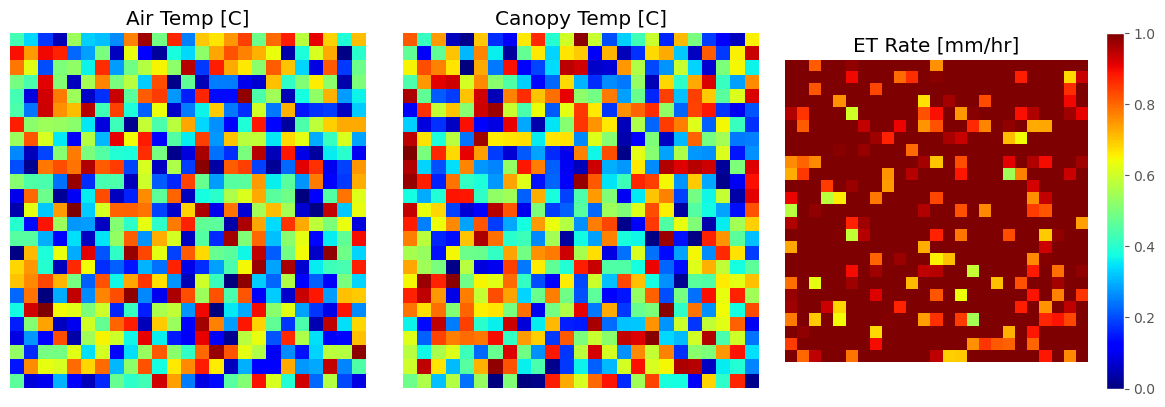

In [9]:
import numpy as np
import matplotlib.pyplot as plt  

# Generate random data
lons = np.random.rand(25, 25) * 360 - 180 
lats = np.random.rand(25, 25) * 180 - 90
tair = 15 + np.random.rand(25, 25) * 10
tcanopy = 10 + np.random.rand(25, 25) * 5

# Define HRMET model
def HRMET(lon, lat, tair, tcanopy):
  return 0.5 + 0.1 * (tair - tcanopy)
  
# Initialize output array  
et = np.zeros_like(lons)

# Calculate ET
for i in range(len(lats)):
  for j in range(len(lons)):
    et[i,j] = HRMET(lons[i,j], lats[i,j], tair[i,j], tcanopy[i,j])

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(tair, cmap='jet')
axs[0].set_title('Air Temp [C]')
axs[0].axis('off')

axs[1].imshow(tcanopy, cmap='jet') 
axs[1].set_title('Canopy Temp [C]')
axs[1].axis('off')

im = axs[2].imshow(et, cmap='jet', vmin=0, vmax=1)
axs[2].set_title('ET Rate [mm/hr]')
axs[2].axis('off')
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

## The end